# Initialization

Import librairies

In [0]:
import os
import zipfile
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Connection to my drive

In [0]:
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Unzipping the file with the images

In [0]:
with zipfile.ZipFile('/content/gdrive/My Drive/BigData/Project/celeba-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Project/')

path = '/content/Project/celeba-dataset/'
path_img = path + 'img_align_celeba/img_align_celeba/'

# Sampling

In [0]:
sample = pickle.load(open('/content/gdrive/My Drive/BigData/Project/Listes sample/Brown_Hair.pkl', 'rb'))

image_sample = []
data_sample = np.zeros((len(sample), 64, 64, 3)) #dimension of the images

count = 0
for file in os.listdir(path_img) :
    if file in sample :
        image = Image.open(path_img + file)
        image = image.resize((64,64))
        data_sample[count] = np.array(image)
        image_sample.append(file)
        if count%10000 == 0 :
            print(count)
        count += 1

0
10000


In [0]:
df_attr = pd.read_csv(path + 'list_attr_celeba.csv')
df_attr.replace(to_replace = -1, value = 0, inplace = True)

brownhair = df_attr[['image_id','Brown_Hair']].set_index('image_id')
brownhair_sample = brownhair.loc[image_sample]
print(brownhair_sample.shape)
brownhair_sample.head()

(20000, 1)


,Brown_Hair
image_id,
058184.jpg,1
060196.jpg,1
147729.jpg,0
053053.jpg,0
096798.jpg,0


In [0]:
brownhair_sample.shape

(20000, 1)

In [0]:
data_sample.shape

(20000, 64, 64, 3)

# Creation of the train and test sets

In [0]:
target = np.array(brownhair_sample['Brown_Hair'])

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data_sample, target, 
                                                    test_size = 0.5)
print(X_train.shape, Y_train.shape)

(10000, 64, 64, 3) (10000,)


# Model

In [0]:
# Layer 1
in1 = Input(shape = (64, 64, 3,))
x1 = Conv2D(64, (3, 3), activation = 'relu')(in1)
x1 = MaxPooling2D(pool_size = (2, 2))(x1)

# Layer 2
x2 = Conv2D(128, (3, 3), activation = 'relu')(x1)
x2 = MaxPooling2D(pool_size = (2, 2))(x2)

# Layer 3
x3 = Conv2D(256, (3, 3), activation = 'relu')(x2)
x3 = MaxPooling2D(pool_size = (2, 2))(x3)

# Layer 4
x4 = Conv2D(512, (3, 3), activation='relu')(x3)
x4 = MaxPooling2D(pool_size = (2, 2))(x4)
x4 = Flatten()(x4)

out1 = Dense(2048, activation = 'relu')(x4)
out = Dense(1, activation = 'sigmoid')(out1)

model_brownhair = Model(inputs = [in1], outputs = [out])
model_brownhair.compile(loss = 'binary_crossentropy', optimizer = 'Adam', 
                         metrics = ['accuracy'])

In [0]:
# Path where we will save our model :
path_model = '/content/gdrive/My Drive/BigData/Project/BestModelBrownHair.hdf5'

# Parameters for fit the model :
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2,
                              patience = 1, min_lr = 0.001)

checkpoint = ModelCheckpoint(path_model, monitor = 'val_accuracy',
                             verbose = 1, save_best_only = True,
                             mode = 'max')

callbacks = [checkpoint, reduce_lr]

In [0]:
model_brownhair.fit(X_train, Y_train, batch_size = 200, epochs = 10, 
                     validation_data = (X_test, Y_test), callbacks = callbacks)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 8.8359 - accuracy: 0.5344
Epoch 00001: val_accuracy improved from -inf to 0.59340, saving model to /content/gdrive/My Drive/BigData/Project/BestModelBrownHair.hdf5
50/50 [==============================] - 133s 3s/step - loss: 8.8359 - accuracy: 0.5344 - val_loss: 0.6514 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.6745
Epoch 00002: val_accuracy improved from 0.59340 to 0.72880, saving model to /content/gdrive/My Drive/BigData/Project/BestModelBrownHair.hdf5
50/50 [==============================] - 134s 3s/step - loss: 0.5984 - accuracy: 0.6745 - val_loss: 0.5487 - val_accuracy: 0.7288 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.5272 - accuracy: 0.7375
Epoch 00003: val_accuracy improved from 0.72880 to 0.74550, saving model to /content/gdrive/My Drive/BigData/Project/BestModelBrownHair.hdf5
50/50 [=====

In [0]:
example_id = '000053.jpg'
example = Image.open(path_img + example_id)

example_resize = example.resize((64, 64))
image_test = np.zeros((1, 64, 64, 3))
image_test[0] = np.array(example_resize)

best_model_brownhair = load_model('/content/gdrive/My Drive/BigData/Project/BestModelBrownHair.hdf5')
pred = best_model_brownhair.predict(image_test, verbose = 1)

1/1 [==============================] - 0s 1ms/step


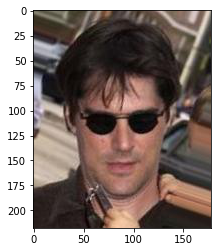

This person has not brown hair


In [0]:
result = lambda x : 'brown hair' if x >= 0.5 else 'not brown hair'

plt.imshow(example)
plt.show()
print("This person has", result(pred[0]))